## Assignment Instructions
Develop and compare CNN and Transformer models for image classification to understand the strengths, weaknesses, and appropriate applications of each architecture. This assignment will help you build practical experience with modern deep learning architectures and their implementation.



The **goal** is to recognize previously unseen images and assign them to one of the ten classes.

The **CIFAR-10** dataset contains 60,000 colour images of 32 x 32 pixels in three channels, divided into 10 classes. Each class contains 6,000 images. The training set contains 50,000 images while the test set provides 10,000 images.

## **Task 1: Utilise Libraries/Dataset**
- Import the necessary libraries (TensorFlow/Keras, NumPy, Matplotlib, etc.)
-Load and explore the CIFAR-10 dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# Load data
def load_data():
  (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  return x_train, y_train, x_test, y_test

# Load data
x_train, y_train, x_test, y_test = load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


### **Image Dimension and basic information about the dataset**

In [3]:
# Print basic information about the dataset
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

# Check data type and range
print("\nData type:", x_train.dtype)
print("Min pixel value:", x_train.min())
print("Max pixel value:", x_train.max())

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

Data type: float32
Min pixel value: 0.0
Max pixel value: 255.0


CIFAR-10 has **50000 training images**, each of size **32 × 32** pixels, with 3 color channels (RGB)

So, each image has shape: 32 x 32 x 3

Same for **test set: 10,000 images**, 32 x 32 x 3

In [4]:
# Define CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

##**Task 2: Generate at least two EDA visualisations**
- Generate at least two EDA visualisations (class distribution and sample images)
- View Class Names and Distribution

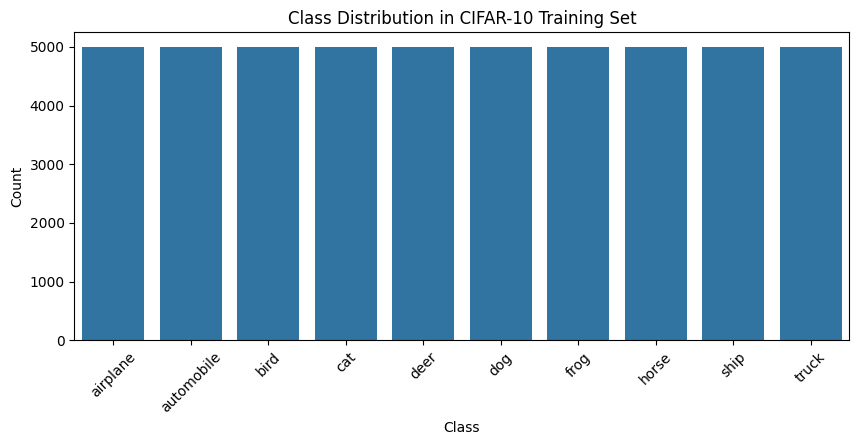

In [5]:
from collections import Counter

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Flatten labels
y_train_flat = y_train.flatten()

# Count labels
label_counts = Counter(y_train_flat)

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.xticks(ticks=range(10), labels=class_names, rotation=45)
plt.title("Class Distribution in CIFAR-10 Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


###**Pixel Value Statistics**

In [6]:
print("Pixel value range:", x_train.min(), "to", x_train.max())

# Normalize to [0, 1] if needed
x_train_norm = x_train / 255.0
print("After normalization -> mean:", np.mean(x_train_norm), "std:", np.std(x_train_norm))


Pixel value range: 0.0 to 255.0
After normalization -> mean: 0.4733649 std: 0.25156906


- Pixel values: Range from 0 to 255
- Normalize them to [0,1] for better training stability).

###**Show Sample Images**

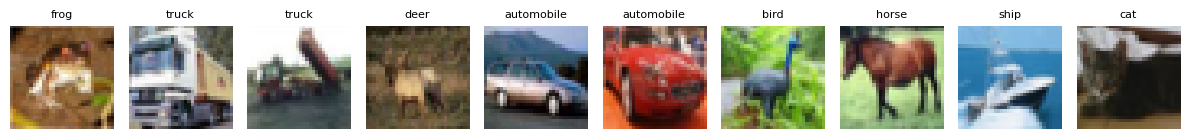

In [7]:
plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[i].astype("uint8"))
    plt.title(class_names[y_train[i][0]], fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

##**Task 3: Analyse data quality**
- Check for missing values or outliers and data quality issues

### **Check for Class Imbalance**

In [8]:
for i, name in enumerate(class_names):
    count = np.sum(y_train == i)
    print(f"{name:10s}: {count} images ({(count / len(y_train)) * 100:.2f}%)")


airplane  : 5000 images (10.00%)
automobile: 5000 images (10.00%)
bird      : 5000 images (10.00%)
cat       : 5000 images (10.00%)
deer      : 5000 images (10.00%)
dog       : 5000 images (10.00%)
frog      : 5000 images (10.00%)
horse     : 5000 images (10.00%)
ship      : 5000 images (10.00%)
truck     : 5000 images (10.00%)


This output confirms that CIFAR-10 is a **perfectly balanced** dataset: Accuracy and other metrics (like precision/recall) won’t be biased towards a particular class.

Each class has 5,000 training images (10% of the dataset each).

There are **10 classes**, totaling **50,000** training images (plus 10,000 test images).

###**Check for Missing Values**

In [9]:
import numpy as np

# Check for NaNs in training and test sets
print("Missing values in x_train:", np.isnan(x_train).sum())
print("Missing values in y_train:", np.isnan(y_train).sum())
print("Missing values in x_test :", np.isnan(x_test).sum())
print("Missing values in y_test :", np.isnan(y_test).sum())


Missing values in x_train: 0
Missing values in y_train: 0
Missing values in x_test : 0
Missing values in y_test : 0


CIFAR-10 has no missing values.

###**Check for Outliers in Pixel Values**

In [10]:
print("x_train min:", x_train.min(), "| max:", x_train.max())
print("x_test min :", x_test.min(), "| max:", x_test.max())


x_train min: 0.0 | max: 255.0
x_test min : 0.0 | max: 255.0



No pixel outliers — all values are within the expected 0–255 range.

###**Check Image Sizes and Shapes**

In [11]:
unique_shapes = {img.shape for img in x_train}
print("Unique image shapes in x_train:", unique_shapes)


Unique image shapes in x_train: {(32, 32, 3)}


All images are 32×32×3, so **no corrupted** or misformatted entries.

##**Task 4: Construct a CNN model(# CIFAR-10 Image Classification using Keras)**
- Construct a CNN model with appropriate layers (convolutional, pooling, fully connected)



In [12]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# 1. Load and preprocess CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [13]:
# Define model
def build_model():
    model = models.Sequential()

    # 1st block
    model.add(layers.Conv2D(32, (3,3), padding='same',
                            input_shape=x_train.shape[1:], activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))

    # 2nd block
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    # 3rd block
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.4))

    # Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax'))  # directly use 10 here

    return model


# Build and compile the model
model1 = build_model()
model1.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,290 (1.18 MB)

 Trainable params: 308,394 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)

##**Task 5: Train the CNN model using the CIFAR-10 dataset**
- Train the model using the training dataset with an appropriate number of training epochs


In [15]:
# Train the model
history_cnn = model1.fit(
    x_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.3698 - loss: 2.3368 - val_accuracy: 0.5512 - val_loss: 1.3559
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6159 - loss: 1.2499 - val_accuracy: 0.6676 - val_loss: 0.9519
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6903 - loss: 0.9642 - val_accuracy: 0.7321 - val_loss: 0.7924
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7257 - loss: 0.8272 - val_accuracy: 0.7373 - val_loss: 0.8123
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7574 - loss: 0.7145 - val_accuracy: 0.7172 - val_loss: 0.8696
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7808 - loss: 0.6433 - val_accuracy: 0.7822 - val_loss: 0.6281
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7961 - loss: 0.5841 - val_accuracy: 0.7631 - val_loss: 0.6940
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8099 - loss: 0.5425 - val_accu

###**Task 6: Display model architecture and training progress**
- Display the model architecture and training progress (take a screenshot of the progress for each epoch)

In [16]:
model1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,686 (2.36 MB)

 Trainable params: 308,394 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 308,396 (1.18 MB)

In [17]:
from google.colab import files
uploaded = files.upload()


Saving epoch_CNN.png to epoch_CNN.png


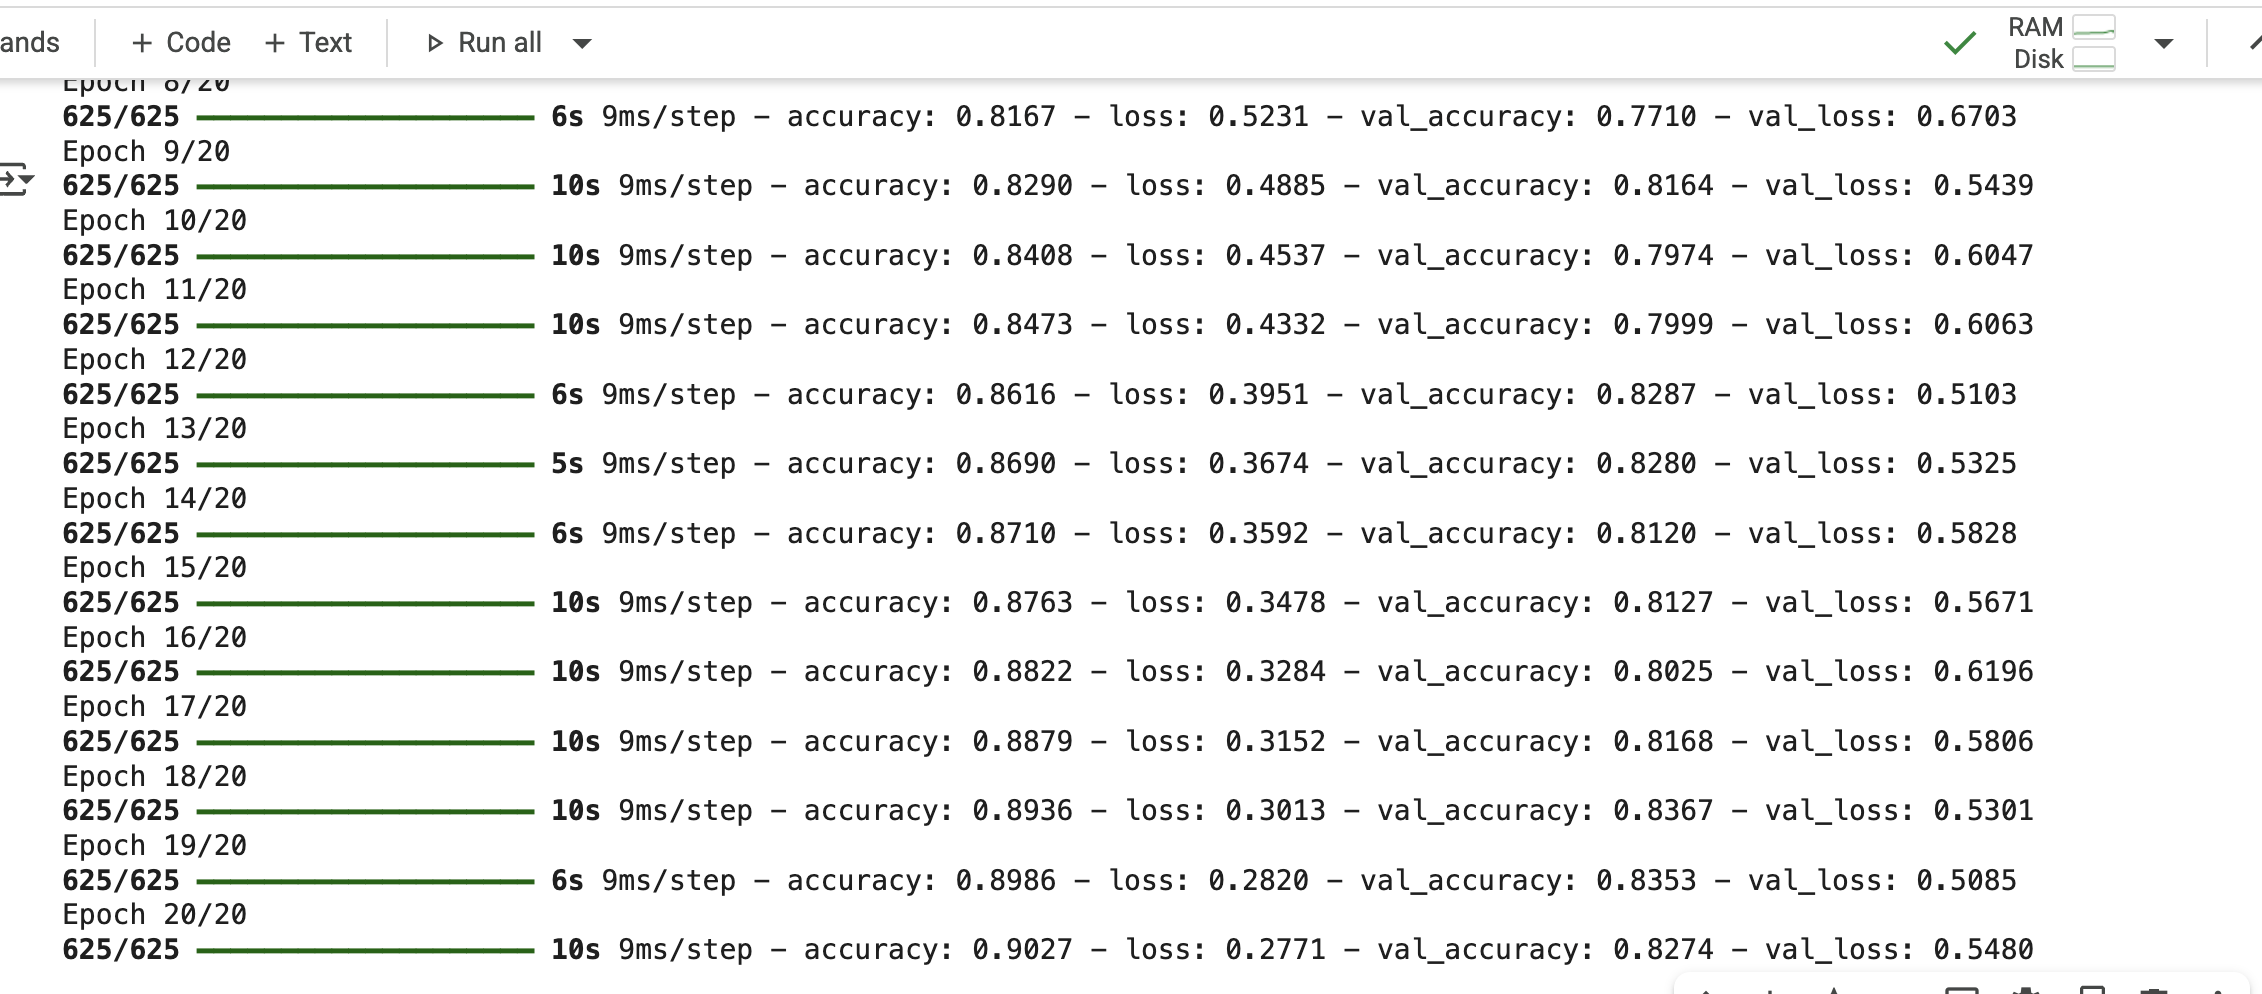

In [18]:
from IPython.display import Image
Image("epoch_CNN.png")

In [19]:
score = model1.evaluate(x_test, y_test, batch_size=64, verbose=1)
print("\nTest Loss:", score[0])
print("Test Accuracy:", score[1])

# Save model architecture
model_json = model1.to_json()
with open("model1_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights (must end in .weights.h5)
model1.save_weights("model1.weights.h5")
print("✅ Model architecture and weights saved to disk.")


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8328 - loss: 0.5423

Test Loss: 0.5337123274803162
Test Accuracy: 0.8342999815940857
✅ Model architecture and weights saved to disk.


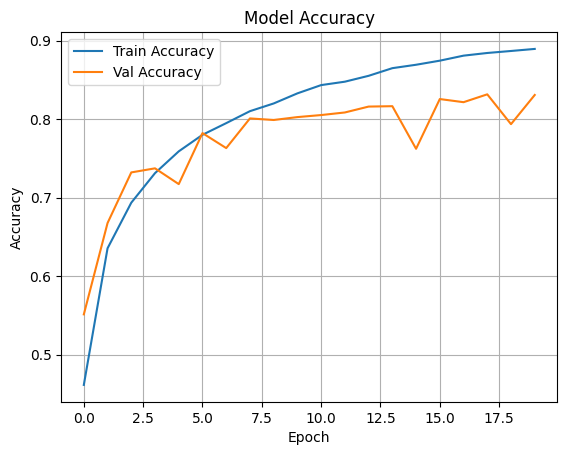

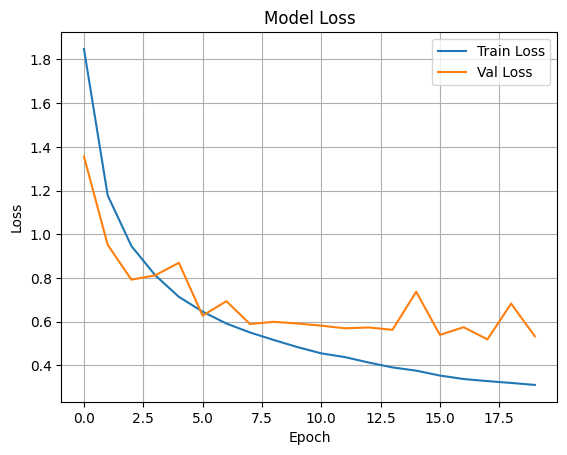

In [20]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
score = model1.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {score[0]:.4f}")
print(f"Test Accuracy: {score[1]:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8330 - loss: 0.5414
Test Loss: 0.5337
Test Accuracy: 0.8343


In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

ckpt = ModelCheckpoint('best_cnn.keras', monitor='val_loss',
                       save_best_only=True, mode='min', verbose=1)
early = EarlyStopping(monitor='val_loss', patience=5,
                      restore_best_weights=True, verbose=1)
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                           patience=3, min_lr=1e-6, verbose=1)

history_cnn = model1.fit(
    x_train, y_train,
    epochs=40,
    batch_size=64,
    validation_split=0.2,
    shuffle=True,
    callbacks=[ckpt, early, reduce],
    verbose=1
)

# Load best weights (if not using restore_best_weights)
# model1 = tf.keras.models.load_model('best_cnn.keras')

test_loss, test_acc = model1.evaluate(x_test, y_test, batch_size=128, verbose=1)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


Epoch 1/40
619/625 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8996 - loss: 0.2827
Epoch 1: val_loss improved from inf to 0.59065, saving model to best_cnn.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8995 - loss: 0.2828 - val_accuracy: 0.8226 - val_loss: 0.5907 - learning_rate: 0.0010
Epoch 2/40
621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8978 - loss: 0.2856
Epoch 2: val_loss improved from 0.59065 to 0.54551, saving model to best_cnn.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8978 - loss: 0.2856 - val_accuracy: 0.8278 - val_loss: 0.5455 - learning_rate: 0.0010
Epoch 3/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9066 - loss: 0.2589
Epoch 3: val_loss did not improve from 0.54551
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9066 - loss: 0.2590 - val_accuracy: 0.8282 - val_loss: 0.5734 - learning_rate: 0.0010
Epoch 4/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9070 - loss: 0.2616
Epoch 4: val_loss did n

In [23]:
# After training
test_loss, test_acc = model1.evaluate(x_test, y_test, batch_size=128, verbose=1)

# Get best training and validation metrics from history
best_epoch = np.argmax(history_cnn.history['val_accuracy'])
best_train_acc = history_cnn.history['accuracy'][best_epoch]
best_val_acc = history_cnn.history['val_accuracy'][best_epoch]
best_train_loss = history_cnn.history['loss'][best_epoch]
best_val_loss = history_cnn.history['val_loss'][best_epoch]

print("\n=== Training Summary ===")
print(f"Best Epoch: {best_epoch+1}")
print(f"Train Accuracy: {best_train_acc:.4f} | Train Loss: {best_train_loss:.4f}")
print(f"Val Accuracy:   {best_val_acc:.4f} | Val Loss:   {best_val_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f} | Test Loss:  {test_loss:.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8501 - loss: 0.4983

=== Training Summary ===
Best Epoch: 11
Train Accuracy: 0.9463 | Train Loss: 0.1480
Val Accuracy:   0.8600 | Val Loss:   0.4882
Test Accuracy:  0.8542 | Test Loss:  0.4862


**Model Evaluation Insights**
Best Epoch: 11

Training Accuracy: 94.63%

Validation Accuracy: 86.00%

Test Accuracy: 85.42%

Validation Loss: 0.4882

Test Loss: 0.4862

**Observations**
- Generalization is strong: validation and test are nearly identical (Δ ≈ 0.58pp), indicating stable performance on unseen data.

- Mild overfitting: train vs. test gap is ≈ 9.2pp (94.6 → 85.4), expected for this architecture and dataset size but not excessive.

- Clear improvement over earlier run: test accuracy rose from 81.72% → 85.42% (≈ +3.7pp), and test loss dropped 0.5731 → 0.4862.

- Best checkpoint matters: the best metrics came around epoch 11; using early stopping / best-weights restoration was beneficial.

In [26]:
import numpy as np

best_epoch = int(np.argmax(history_cnn.history['val_accuracy'])) + 1
print("Best epoch:", best_epoch)

model1.save(f"cnn_best_epoch{best_epoch}.keras")


Best epoch: 11


##**Task 7: Construct a ViT model**
- Implement a Vision Transformer (ViT) model with attention mechanisms

In [27]:
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# ========================
# CONFIGURATION
# ========================
num_classes = 10
input_shape = (32, 32, 3)

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

# One-hot encode labels
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# ========================
# HYPERPARAMETERS
# ========================
learning_rate = 1e-3
weight_decay = 1e-4
batch_size = 128
num_epochs = 20
image_size = 80
patch_size = 8
num_patches = (image_size // patch_size) ** 2
projection_dim = 72
num_heads = 6
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 6
mlp_head_units = [512, 256]

# ========================
# DATA AUGMENTATION
# ========================
data_augmentation = keras.Sequential([
    layers.Normalization(),
    layers.Resizing(image_size, image_size),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1, 0.1),
], name="data_augmentation")
data_augmentation.layers[0].adapt(x_train)

# ========================
# MLP BLOCK
# ========================
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# ========================
# PATCHES LAYER
# ========================
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        patches = ops.image.extract_patches(images, size=self.patch_size)
        batch_size = ops.shape(images)[0]
        patches = ops.reshape(patches, [batch_size, -1, patches.shape[-1]])
        return patches

# ========================
# PATCH ENCODER
# ========================
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(num_patches, projection_dim)

    def call(self, patches):
        positions = ops.arange(start=0, stop=num_patches, step=1)
        projected_patches = self.projection(patches)
        return projected_patches + self.position_embedding(positions)

# ========================
# BUILD VIT MODEL
# ========================
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization()(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim,
            dropout=0.1  # Added dropout inside attention
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization()(x2)
        x3 = mlp(x3, transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization()(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    features = mlp(representation, mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


##**Task 8: Train the ViT model using the CIFAR-10 dataset**
Train the ViT model using the training dataset with an appropriate number of training epochs.

In [31]:
from tensorflow import keras
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
#===================
# BUILD MODEL AGAIN
#===================
model_vit = create_vit_classifier()

# --- Optimizer: AdamW + cosine decay ---
steps_per_epoch = (x_train.shape[0] * 0.8) // batch_size  # since validation_split=0.2
decay_steps = int(steps_per_epoch * 10)  # ~10 epochs per cosine cycle (tweak if you like)

lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps
)

optimizer = AdamW(learning_rate=lr_schedule, weight_decay=weight_decay)

#=================
# --- COMPILE ---
#=================
model_vit.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

#=====================
# --- CALLBACKS ---
#=====================
ckpt = ModelCheckpoint(
    "vit_best.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)
early = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)
reduce = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

#===================
# --- TRAIN MODEL---
#===================
history_vit = model_vit.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[ckpt, early, reduce],
    shuffle=True,
    verbose=1
)

#=============================
# --- EVALUATE TEST SET ---
#=============================
test_loss, test_acc = model_vit.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print(f"[ViT] Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

#===========================================
# --- SUMMARIZE BEST EPOCH ---
#===========================================
best_epoch = int(np.argmax(history_vit.history['val_accuracy']))
best_train_acc = history_vit.history['accuracy'][best_epoch]
best_val_acc   = history_vit.history['val_accuracy'][best_epoch]
best_train_loss= history_vit.history['loss'][best_epoch]
best_val_loss  = history_vit.history['val_loss'][best_epoch]

print("\n=== ViT Training Summary ===")
print(f"Best Epoch: {best_epoch+1}")
print(f"Train Accuracy: {best_train_acc:.4f} | Train Loss: {best_train_loss:.4f}")
print(f"Val   Accuracy: {best_val_acc:.4f} | Val   Loss: {best_val_loss:.4f}")
print(f"Test  Accuracy: {test_acc:.4f} | Test  Loss: {test_loss:.4f}")


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.2557 - loss: 2.0525
Epoch 1: val_accuracy improved from -inf to 0.40990, saving model to vit_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - accuracy: 0.2559 - loss: 2.0522 - val_accuracy: 0.4099 - val_loss: 1.7442 - learning_rate: 9.7537e-04
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.4161 - loss: 1.7495
Epoch 2: val_accuracy improved from 0.40990 to 0.47570, saving model to vit_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 165ms/step - accuracy: 0.4162 - loss: 1.7495 - val_accuracy: 0.4757 - val_loss: 1.6313 - learning_rate: 9.0392e-04
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.4838 - loss: 1.6199
Epoch 3: val_accuracy improved from 0.47570 to 0.53530, saving model to vit_best.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 171ms/step - accuracy: 0.4838 - loss: 1.6199 - val_accuracy: 0.5353 - val_loss: 1.5149 - learning_rate: 7.9267e-04
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━

##**Task 9: Display model architecture and training progress**

In [33]:
# Show a summary of the ViT model
model_vit.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 80, 80, 3) │          7 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_1 (Patches) │ (None, None, 192) │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_1     │ (None, 100, 72)   │     21,096 │ patches_1[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 72)   │        144 │ patch_encoder_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 72)   │    125,784 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 100, 72)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 72)   │        144 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 100, 144)  │     10,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 100, 144)  │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 100, 72)   │     10,440 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 100, 72)   │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 100, 72)   │          0 │ dropout_25[0][0], │
│                     │                   │            │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 72)   │        144 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 72)   │    125,784 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 100, 72)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 72)   │        144 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 100, 144)  │     10,512 │ layer_normalizat

 Total params: 3,223,982 (12.30 MB)

 Trainable params: 1,074,658 (4.10 MB)

 Non-trainable params: 7 (32.00 B)

 Optimizer params: 2,149,317 (8.20 MB)

###**Plot the training and validation accuracy/loss**

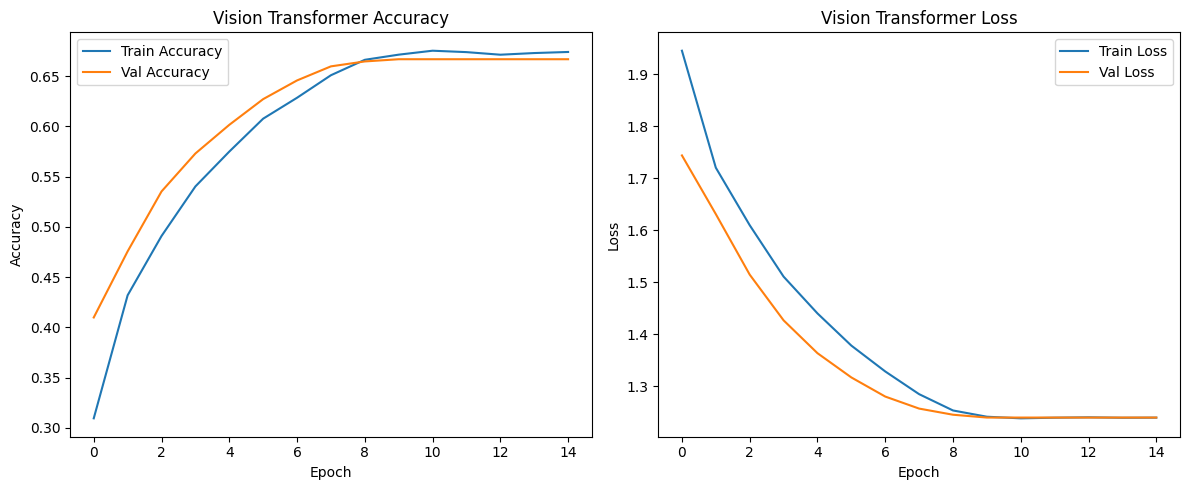

In [34]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_vit.history['accuracy'], label='Train Accuracy')
plt.plot(history_vit.history['val_accuracy'], label='Val Accuracy')
plt.title('Vision Transformer Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_vit.history['loss'], label='Train Loss')
plt.plot(history_vit.history['val_loss'], label='Val Loss')
plt.title('Vision Transformer Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


###**Model Evaluation Insights – Vision Transformer (ViT)**

Best Epoch: 10

Training Accuracy: ~67.15%

Validation Accuracy: ~66.69%

Test Accuracy: ~65.77%

Test Loss: 1.2463

**Observations**

The ViT model shows steady improvement during training, with both training and validation accuracy curves converging around ~67%, indicating stable learning.

The near-overlap of training and validation loss curves suggests low overfitting, but also points to the model’s limited capacity to further close the accuracy gap with stronger baselines like CNNs.

Accuracy gains plateau after epoch 8–10, indicating that additional epochs provide minimal benefit under the current architecture and hyperparameters.

Performance suggests the model is learning meaningful patterns but struggles to fully leverage CIFAR-10’s spatial information compared to convolutional architectures.

##**Task 10: Compare training and validation results for each model:**-
Discuss the difference in performance, training efficiency and learning dynamics or learning patterns of each model


| Metric                           | CNN Model    | Vision Transformer (ViT) |
| -------------------------------- | ------------ | ------------------------ |
| **Best Epoch**                   | 11           | 10                       |
| **Train Accuracy**               | 94.63%       | 67.15%                   |
| **Train Loss**                   | 0.1480       | 1.2415                   |
| **Val Accuracy**                 | 86.00%       | 66.69%                   |
| **Val Loss**                     | 0.4882       | 1.2398                   |
| **Test Accuracy**                | 85.42%       | 65.77%                   |
| **Test Loss**                    | 0.4862       | 1.2463                   |
| **Performance Gap** (Train–Test) | \~9.21% drop | \~1.38% drop             |


**Analysis**
**Performance Gap**
- CNN shows a larger train–test gap (~9.2%), indicating some overfitting but still strong generalization.

- ViT has a very small train–test gap (~1.4%), suggesting balanced training but overall lower accuracy, likely due to insufficient data or model complexity.

**Training Efficiency**
- CNN converged faster to high accuracy, reaching above 80% validation accuracy within the first 10 epochs.

- ViT had a more gradual improvement, plateauing around 66–67% accuracy, suggesting that it needs either more epochs, larger datasets, or stronger regularization.

**Learning Patterns/Dynamics**
- CNN shows clear overfitting signs after its best epoch (accuracy rises but validation stagnates), common in small-to-medium datasets.

- ViT maintained close tracking between training and validation accuracy, indicating stable learning but possibly underfitting due to limited capacity to extract inductive biases without more data.